In [ ]:
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from tqdm.auto import tqdm
from torchvision.utils import make_grid

In [ ]:
# hyperparameters
valid_size=0.2
batch_size=128
epochs=20
lr= 1e-3
nrm_mean=0.5
nrm_std=0.5
num_workers=0

root_ds = "D:\GitHub\pytorch-lab\Dataset" # dataset root
root_bm = "D:\GitHub\pytorch-lab\Best_Models" # best models root

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transform
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((nrm_mean,) , (nrm_std,))
])

In [ ]:
#load dataset
train_data=datasets.MNIST(root=root_ds,
                          train=True, transform=trans, download=True)

test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

In [ ]:
#sampler
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
#dataloader
train_loader=DataLoader(train_data, batch_size= batch_size, num_workers=num_workers, sampler=train_sampler)
valid_loader=DataLoader(train_data, batch_size= batch_size, num_workers=num_workers, sampler=valid_sampler)
test_loader =DataLoader(test_data,  batch_size= batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
def dense(num_in, num_out):
    return nn.Sequential(
        nn.Linear(num_in, num_out),
        nn.BatchNorm1d(num_out),
        nn.ReLU(inplace=True),
        )

In [ ]:
def decoder(image_dim, num_hidden):
    return nn.Sequential(
        dense(image_dim, 4*num_hidden),
        dense(4*num_hidden, 2*num_hidden),
        dense(2*num_hidden, num_hidden)
    )

In [ ]:
def encoder(num_hidden, image_dim):
    return nn.Sequential(
        dense(num_hidden, 2*num_hidden),
        dense(2*num_hidden, 4*num_hidden),
        dense(4*num_hidden, image_dim)
    )

In [ ]:
class Net(nn.Module):
    def __init__(self, image_dim, num_hidden):
        super(Net, self).__init__()

        self.decod = decoder(image_dim, num_hidden)
        self.encod = encoder(num_hidden, image_dim)

    def forward(self, x):
        x=torch.flatten(x, start_dim=1)
        x = self.decod(x)
        x = self.encod(x)
        return x

In [ ]:
# instance of model
model=Net(784, 128).to(device)
# criterion
criterion = nn.MSELoss()
# optimizer
optimizer=optim.Adam(model.parameters(), lr=lr)

In [ ]:
# helper function
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
for epoch in range(1,epochs+1):
    # !!!
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # loss/acc all training data
    loss_train, loss_valid = 0, 0

    # Set mode on "train mode"
    model.train()
    for iter_train, (image, _) in enumerate(tqdm(train_loader), 1):
        # Transfer training data on desired device
        image = image.to(device)

        # "require_grad" have accumulating property
        optimizer.zero_grad()

        # Feed training data to model
        y_hat = model(image)

        # average of mini-batch loss & mini-batch accuracy
        loss = criterion(y_hat, torch.flatten(image, start_dim=1))

        # summation of all mini-batches loss (loss of all data)
        # & summation of all mini-batches accuracy (accuracy of all data)
        loss_train += loss.item() * image.size(0)

        # Gradient
        loss.backward()

        # Update all parameters that embedded on "optimizer".
        # Update all parameters that "require_grad" is true.
        optimizer.step()

    # average loss/accuracy of all training data
    loss_train /= len(train_loader.sampler)

    # Display average loss/accuracy of all training data
    print("Loss_Train: {:.2f}".format(loss_train))

    model.eval()
    for iter_valid, (image, _) in enumerate(valid_loader, 1):
        # in evaluation phase, we don't need to use gradient because of lack of updating.
        with torch.no_grad():
            # Transfer training data on desired device
            image = image.to(device)

            # Feed training data to model
            y_hat = model(image)

            # average of mini-batch loss & mini-batch accuracy
            loss = criterion(y_hat, torch.flatten(image, start_dim=1))

            # summation of all mini-batches loss (loss of all data)
            # & summation of all mini-batches accuracy (accuracy of all data)
            loss_valid += loss.item() * image.size(0)

            # for show
            if iter_valid == 1 :
                image_show = image

    # average loss/accuracy of all training data
    loss_valid /= len(valid_loader.sampler)

    # Display average loss/accuracy of all training data
    print("Loss_Valid: {:.2f}".format(loss_valid))

    show_tensor_images(model(image_show))

# Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


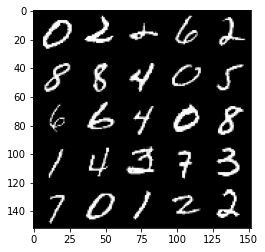

In [184]:
# one mini-batch of validation data
show_tensor_images((image_show))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


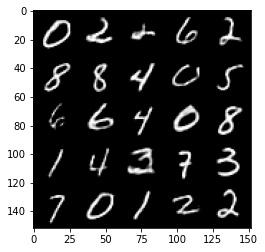

In [185]:
# output of AE for one mini-batch of validation data
show_tensor_images(model(image_show))

# Feed Noise to Encoder module of trained model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


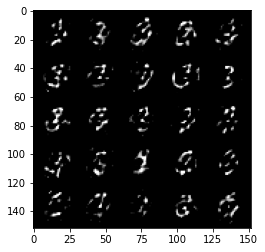

In [196]:
# create noise images (number of images = 128, number of pixels = 128)
noise_input = torch.normal(mean = 0*torch.ones(128,128), std = 1*torch.ones(128,128)).to(device)
show_tensor_images(model.encod(noise_input))

# Question : Why can't generate a realistic images?